## 登入google帳戶以讀存取資料



In [1]:
from google.colab import drive
drive.mount('/b05501039@g.ntu.edu.tw/')  #登入google帳戶以讀存取資料

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /b05501039@g.ntu.edu.tw/


## 設定Tensorflow版本與測試GPU

In [2]:
%tensorflow_version 1.x  #切換tf版本(colab指令)
import tensorflow as tf
gpu_device_name = tf.test.gpu_device_name()
print(gpu_device_name) #確定device name
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess) #查看使用中的GPU

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  #切換tf版本(colab指令)`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
/device:GPU:0
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



## Import Package

In [3]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.optimizers import RMSprop, Adam
from keras.layers import LSTM, Activation, CuDNNLSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from sklearn.externals import joblib  # save scaler
from random import shuffle

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Function

In [ ]:
def ScalingInput(train,test):
    train_flatten = np.reshape(train, [train.shape[0]*train.shape[1]*train.shape[2],1])  
    test_flatten = np.reshape(test, [test.shape[0]*test.shape[1]*test.shape[2],1]) 
    scaler_X = MinMaxScaler(feature_range=(-1, 1))  #標準化器
    scaler_X.fit(train_flatten)  #對應到要縮放的資料
    train_flatten_map = scaler_X.transform(train_flatten)  
    train_map = np.reshape(train_flatten_map, [train.shape[0], train.shape[1], train.shape[2]]) 
    test_flatten_map = scaler_X.transform(test_flatten)  
    test_map = np.reshape(test_flatten_map, [test.shape[0], test.shape[1], test.shape[2]]) 
    return train_map, test_map, scaler_X
 
def ScalingOutput(train,test):
    train_flatten = np.reshape(train, [train.shape[0]*train.shape[1] ,train.shape[2]])  
    test_flatten = np.reshape(test, [test.shape[0]*test.shape[1], test.shape[2]]) 
    scaler_y = MinMaxScaler(feature_range=(-1, 1))  #標準化器
    scaler_y.fit(train_flatten)  #對應到要縮放的資料
    train_flatten_map = scaler_y.transform(train_flatten)  
    train_map = np.reshape(train_flatten_map, [train.shape[0], train.shape[1], train.shape[2]]) 
    test_flatten_map = scaler_y.transform(test_flatten)  
    test_map = np.reshape(test_flatten_map, [test.shape[0], test.shape[1], test.shape[2]]) 
    return train_map, test_map, scaler_y

def prediction(X_scale_stack,y_scale_stack):
  pred = model.predict(X_scale_stack) 
  pred_flatten = np.reshape(pred, [pred.shape[0]*pred.shape[1], pred.shape[2]])  
  pred = scaler_y_Disp.inverse_transform(pred_flatten)  #將預測數值縮放回原大小 
  pred = np.reshape(pred, [y_scale_stack.shape[0], y_scale_stack.shape[1], y_scale_stack.shape[2]])  
  return pred


def MSE(Response_true,Response_pred):
  ErrorList=[]
  for i in range(Response_true.shape[0]):
      for k in range(Response_true.shape[2]):
        true_std = (Response_true[i,:,k] - Response_true[i,:,k].min()) / (Response_true[i,:,k].max() - Response_true[i,:,k].min())
        true_scaled = true_std * (1-(-1)) + (-1)
        pred_std = (Response_pred[i,:,k] - Response_true[i,:,k].min()) / (Response_true[i,:,k].max() - Response_true[i,:,k].min())
        pred_scaled = pred_std * (1-(-1)) + (-1)

        ErrorList.append( sum((pred_scaled- true_scaled)**2)/Response_true.shape[1] ) 
  Mse = np.array(ErrorList).reshape(Response_true.shape[0],Response_true.shape[2])
  return Mse

def PeakError(Response_true,Response_pred):
  ErrorList=[]
  for i in range(Response_true.shape[0]):
    for k in range(Response_true.shape[2]):
      Maxarg = np.argmax(Response_true[i,:,k])
      peak_error = (Response_pred[i,Maxarg,k] - Response_true[i,:,k].max())/Response_true[i,:,k].max()
      ErrorList.append(peak_error*100)
  Peak_Error = np.array(ErrorList).reshape(Response_true.shape[0],Response_true.shape[2])
  return Peak_Error

## Training

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, None, 100)         44800     
_________________________________________________________________
activation_1 (Activation)    (None, None, 100)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, None, 100)         80800     
_________________________________________________________________
activation_2 (Activation)    (None, None, 100)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 100)         0         
_______________________________________

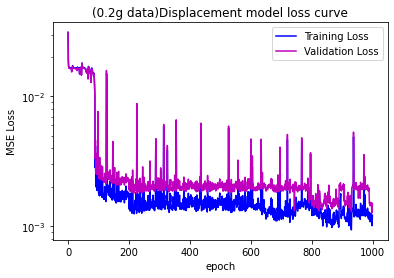

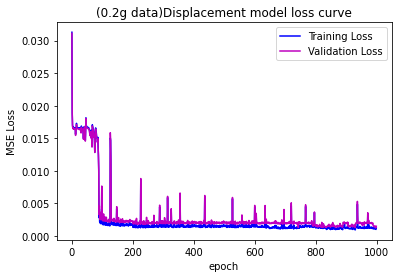

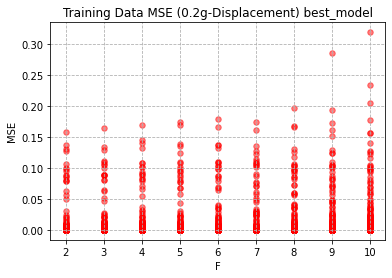

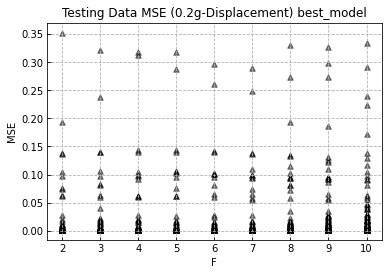

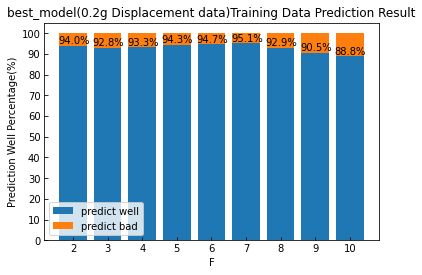

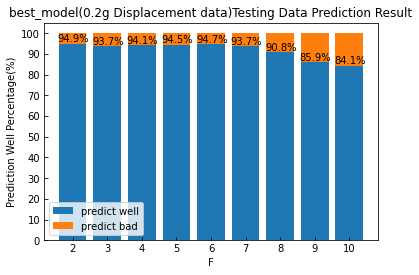

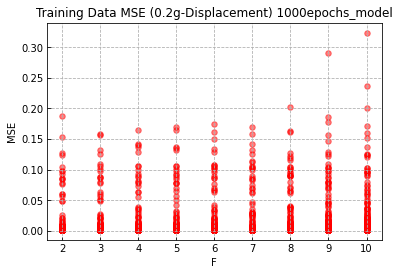

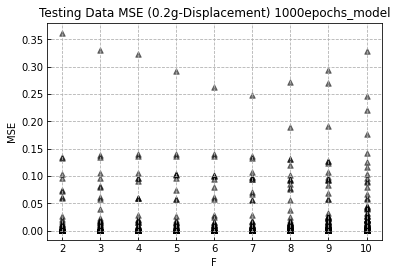

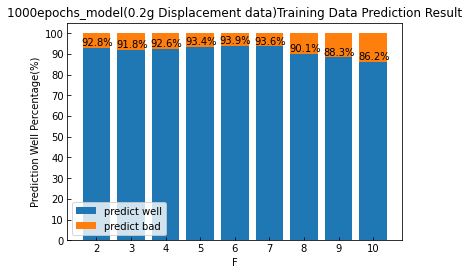

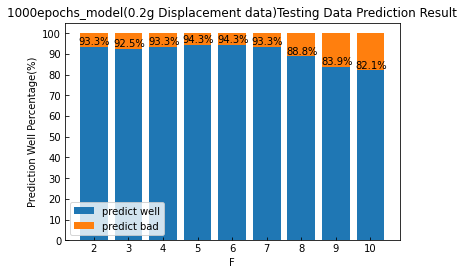

In [ ]:
# Load training data and validation data
dataDir = '/b05501039@g.ntu.edu.tw/My Drive/AI center intern/nonlinear_seismic_response_analysis/August/0.2g_Earthquake/'  
resultDir = '/b05501039@g.ntu.edu.tw/My Drive/AI center intern/nonlinear_seismic_response_analysis/August/0.2g_Earthquake/Disp/0.2gDisp6/'  
mat_data = scipy.io.loadmat(dataDir+'NewData_Disp.mat')

# original data
X_train_stack = mat_data['X_train_stack']
y_Disp_train_stack = mat_data['y_Disp_train_stack']
X_test_stack = mat_data['X_test_stack']
y_Disp_test_stack = mat_data['y_Disp_test_stack']
name_train = mat_data['name_train']
steps_train = mat_data['step_train']
name_test = mat_data['name_test']
steps_test = mat_data['step_test']
X_train_scale_stack, X_test_scale_stack, scaler_X = ScalingInput(X_train_stack,X_test_stack)
y_Disp_train_scale_stack, y_Disp_test_scale_stack, scaler_y_Disp = ScalingOutput(y_Disp_train_stack,y_Disp_test_stack)

# Save scaler
joblib.dump(scaler_X, resultDir+ 'scaler_X.save')
joblib.dump(scaler_y_Disp, resultDir+ 'scaler_y_Disp.save')

#-------------------------------------------------------------------------------
# Building model
data_dim = X_train_scale_stack.shape[2]  # number of input features
timesteps = X_train_scale_stack.shape[1]
num_classes = y_Disp_train_scale_stack.shape[2]  # number of output features
batch_size = 16
rms = RMSprop(lr=0.001, decay=0.0001)
adam = Adam(lr=0.001, decay=0.0001)

#-------------------------------------------------------------------------------
model = Sequential()
model.add(CuDNNLSTM(100, return_sequences=True, stateful=False, input_shape=(None, data_dim), recurrent_regularizer=regularizers.l2(0.001)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(100, return_sequences=True, stateful=False))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.summary()
model.compile(loss='mean_squared_error',  # categorical_crossentropy, mean_squared_error, mean_absolute_error
              optimizer=adam,  # RMSprop(), Adagrad, Nadam, Adagrad, Adadelta, Adam, Adamax,
              metrics=['mse'])
best_loss = 100
train_loss = []
validation_loss = []
history = []

#-------------------------------------------------------------------------------
# Training
with tf.device('/device:GPU:0'):  #指定session在GPU:0上運行，在colab上也不需要特別指定
    #限制GPU使用率
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True  #動態申請顯存
    # config.gpu_options.per_process_gpu_memory_fraction = 0.4  #限制GPU使用率為40%
    session = tf.Session(config=config)
    # tf.Session(config=tf.ConfigProto(log_device_placement=True))

#-------------------------------------------------------------------------------
    start = time.time()
    epochs = 1000  
    Ind = list(range(len(X_train_scale_stack)))
    shuffle(Ind)
    ratio_split = 0.8
    Ind_train = Ind[0:round(ratio_split*len(X_train_scale_stack))]
    Ind_validation = Ind[round(ratio_split*len(X_train_scale_stack)):]
    X_train = X_train_scale_stack[Ind_train]
    y_train = y_Disp_train_scale_stack[Ind_train]
    X_validation = X_train_scale_stack[Ind_validation]
    y_validation = y_Disp_train_scale_stack[Ind_validation]
    for e in range(epochs):
        print('epoch = ', e + 1)
#-------------------------------------------------------------------------------
        model.fit(X_train, y_train,
                  batch_size=batch_size,
                  # validation_split=0.3,
                  validation_data=(X_validation, y_validation),
                  shuffle=True,
                  epochs=1)
        score0 = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
        score = model.evaluate(X_validation, y_validation, batch_size=batch_size, verbose=0)
        train_loss.append(score0[0]) 
        validation_loss.append(score[0])

        # Save the best trained model with minimum testing loss
        if validation_loss[e] <= best_loss:
            best_epoch = e
            best_loss = validation_loss[e]
            model.save(resultDir+'best_model.h5')
#-------------------------------------------------------------------------------
    model.save(resultDir+'1000epochs_model.h5')    
    end = time.time()
    running_time = (end - start)/3600
    print('Running Time: ', running_time, ' hour')
    print('best_epoch: ', best_epoch)
#-------------------------------------------------------------------------------
# Plot training and validation loss
plt.figure()
plt.plot(np.array(train_loss), 'b-',label='Training Loss')
plt.plot(np.array(validation_loss), 'm-',label='Validation Loss')
plt.title('(0.2g data)Displacement model loss curve')
plt.xlabel('epoch')
plt.ylabel('MSE Loss')
plt.legend()
ax = plt.gca()
ax.set_yscale('log')
plt.savefig(resultDir+'Disp02g_loss_curve(log).png')    

plt.figure()
plt.plot(np.array(train_loss), 'b-',label='Training Loss')
plt.plot(np.array(validation_loss), 'm-',label='Validation Loss')
plt.title('(0.2g data)Displacement model loss curve')
plt.xlabel('epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.savefig(resultDir+'disp02g_loss_curve(linear).png')    

#-------------------------------------------------------------------------------
# 儲存資料與訓練結果
scipy.io.savemat(resultDir+'Disp02g_reult.mat',
                 { 'train_loss': train_loss,'validation_loss':validation_loss,'best_loss':best_loss})

# Predict Training data and Testing data  
y_Disp_train_stack_pred = prediction(X_train_scale_stack,y_Disp_train_scale_stack)
y_Disp_test_stack_pred = prediction(X_test_scale_stack, y_Disp_test_scale_stack)

ModelList = ['best_model','1000epochs_model']
for Model in ModelList:
    model = load_model(resultDir + Model + '.h5')
        
    # Predict Training data and Testing data  
    y_train_stack_pred = prediction(X_train_scale_stack,y_Disp_train_scale_stack)
    y_test_stack_pred = prediction(X_test_scale_stack, y_Disp_test_scale_stack)    
    #-------------------------------------------------------------------------------
    # normalized MSE
    Train_MSE = MSE(y_Disp_train_stack,y_train_stack_pred)
    Test_MSE = MSE(y_Disp_test_stack,y_test_stack_pred)
    
    #-------------------------------------------------------------------------------
    # 繪製MSE分布
    plt.figure()
    for i in range(1,10):
      plt.scatter((np.ones(Train_MSE.shape[0])+i).astype(np.int8),Train_MSE[:,i-1],s=30,c='red',marker='o',alpha=0.5,)
    plt.title('Training Data MSE (0.2g-Displacement) '+Model)
    plt.xlabel('F')
    plt.ylabel('MSE')
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.grid(linestyle='--')
    plt.savefig(resultDir+Model+' Train_MSE.png')    
    
    plt.figure()
    for i in range(1,10):
      plt.scatter((np.ones(Test_MSE.shape[0])+i).astype(np.int8),Test_MSE[:,i-1],s=30,c='black',marker='^',alpha=0.5,)
    plt.title('Testing Data MSE (0.2g-Displacement) '+Model)
    plt.xlabel('F')
    plt.ylabel('MSE')
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.grid(linestyle='--')
    plt.savefig(resultDir+Model+' Test_MSE.png')    
    
    #-------------------------------------------------------------------------------
    # 繪製MSE百分比圖
    PerformanceIndex = 0.005
    MSEList = [[Train_MSE,'(0.2g Displacement data)Training'],[Test_MSE,'(0.2g Displacement data)Testing']]
    for sample in MSEList:
      GoodList = []
      BadList = []
      for i in range(9):
        StoryMSE = sample[0][:,i]
        GoodData = StoryMSE[StoryMSE<=PerformanceIndex]
        GoodList.append(GoodData.shape[0]/StoryMSE.shape[0]*100)
        BadList.append(100 - GoodData.shape[0] / StoryMSE.shape[0]*100)
    
      x = np.arange(9)+2
      plt.figure()
      plt.bar(x, GoodList, label='predict well')
      plt.bar(x, BadList, bottom=GoodList,label='predict bad')
      for xy in zip(x, GoodList):
        plt.annotate("%.1f" %xy[1]+'%', xy=xy, xytext=(-15, 2), textcoords='offset points')
      plt.title(Model+sample[1]+' Data Prediction Result')
      plt.xlabel('F')
      plt.ylabel('Prediction Well Percentage(%)')
      plt.xticks(x)
      plt.yticks(np.arange(0, 105, 10))
      plt.legend(loc = 'lower left') 
      plt.savefig(resultDir+Model+sample[1]+'Percentage.png')    








## Prediction And Plot total Floors Response

In [4]:
#-------------------------------------------------------------------------------
# Load training data and validation data
dataDir = '/b05501039@g.ntu.edu.tw/My Drive/AI center intern/nonlinear_seismic_response_analysis/August/0.2g_Earthquake/'  #steps, name
resultDir = '/b05501039@g.ntu.edu.tw/My Drive/AI center intern/nonlinear_seismic_response_analysis/August/0.2g_Earthquake/Disp/0.2gDisp6/'  #X_stack, y_stack, 
mat_data = scipy.io.loadmat(dataDir+'NewData_Disp.mat')

# original data
X_train_stack = mat_data['X_train_stack']
y_Disp_train_stack = mat_data['y_Disp_train_stack']
X_test_stack = mat_data['X_test_stack']
y_Disp_test_stack = mat_data['y_Disp_test_stack']

X_train_scale_stack, X_test_scale_stack, scaler_X = ScalingInput(X_train_stack,X_test_stack)
y_Disp_train_scale_stack, y_Disp_test_scale_stack, scaler_y_Disp = ScalingOutput(y_Disp_train_stack,y_Disp_test_stack)

# earthquake
name_train = mat_data['name_train']
name_test = mat_data['name_test']
steps_train = mat_data['step_train']
steps_test = mat_data['step_test']

#-------------------------------------------------------------------------------
# Load the best model
model = load_model(resultDir+'best_model.h5')


# Predict Training data and Testing data  
y_Disp_train_stack_pred = prediction(X_train_scale_stack,y_Disp_train_scale_stack)
y_Disp_test_stack_pred = prediction(X_test_scale_stack, y_Disp_test_scale_stack)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



## Normalized MSE
自定義正規化之Mean Square Error

In [5]:
Train_MSE = MSE(y_Disp_train_stack,y_Disp_train_stack_pred)
Test_MSE = MSE(y_Disp_test_stack,y_Disp_test_stack_pred)
Train_PeakError = PeakError(y_Disp_train_stack,y_Disp_train_stack_pred)
Test_PeakError = PeakError(y_Disp_test_stack,y_Disp_test_stack_pred)

## Plot Normalized MSE distribution

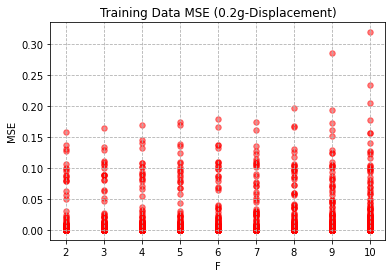

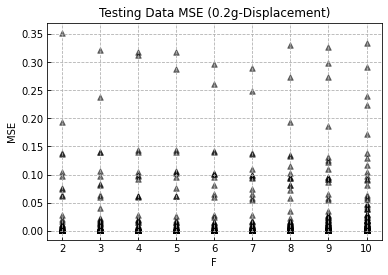

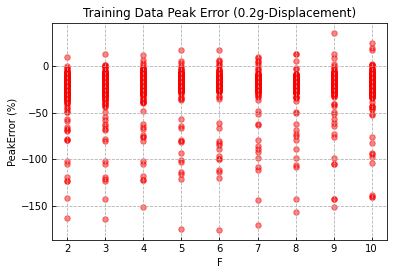

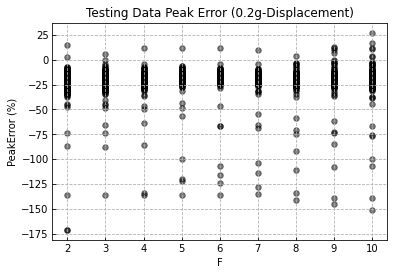

In [6]:
## Normalized MSE
plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Train_MSE.shape[0])+i).astype(np.int8),Train_MSE[:,i-1],s=30,c='red',marker='o',alpha=0.5,)
plt.title('Training Data MSE (0.2g-Displacement)')
plt.xlabel('F')
plt.ylabel('MSE')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Test_MSE.shape[0])+i).astype(np.int8),Test_MSE[:,i-1],s=30,c='black',marker='^',alpha=0.5,)
plt.title('Testing Data MSE (0.2g-Displacement)')
plt.xlabel('F')
plt.ylabel('MSE')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

## Peak Error
plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Train_PeakError.shape[0])+i).astype(np.int8),Train_PeakError[:,i-1],s=30,c='red',marker='o',alpha=0.5,)
plt.title('Training Data Peak Error (0.2g-Displacement)')
plt.xlabel('F')
plt.ylabel('PeakError (%)')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')

plt.figure()
for i in range(1,10):
  plt.scatter((np.ones(Test_PeakError.shape[0])+i).astype(np.int8),Test_PeakError[:,i-1],s=30,c='black',marker='o',alpha=0.5,)
plt.title('Testing Data Peak Error (0.2g-Displacement)')
plt.xlabel('F')
plt.ylabel('PeakError (%)')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.grid(linestyle='--')





## Arrange index (bad to good)
將預測表現最差到最好的資料index依序排列

In [7]:
top_Test = []
top_Train = []
for i in range(9):
  print('%d樓最大MSE Testing data index: '%(i+2),np.argmax(Test_MSE[:,i]))
  print('%d最大MSE Training data index: '%(i+2),np.argmax(Train_MSE[:,i]))
  
  sort_test = Test_MSE[:,i].copy()
  sort_test.sort()
  sort_train = Train_MSE[:,i].copy()
  sort_train.sort()
  for j in range(1,sort_test.size+1):
    top_Test.append(np.where(Test_MSE[:,i]==sort_test[-j])[0][0])
  for k in range(1,sort_train.size+1):
    top_Train.append(np.where(Train_MSE[:,i]==sort_train[-k])[0][0])
top_Test = np.array(top_Test).reshape(Test_MSE.shape[1],Test_MSE.shape[0])  #[樓層,資料數]
top_Train = np.array(top_Train).reshape(Train_MSE.shape[1],Train_MSE.shape[0])  #[樓層,資料數]


2樓最大MSE Testing data index:  123
2最大MSE Training data index:  519
3樓最大MSE Testing data index:  123
3最大MSE Training data index:  519
4樓最大MSE Testing data index:  123
4最大MSE Training data index:  519
5樓最大MSE Testing data index:  290
5最大MSE Training data index:  519
6樓最大MSE Testing data index:  290
6最大MSE Training data index:  519
7樓最大MSE Testing data index:  290
7最大MSE Training data index:  519
8樓最大MSE Testing data index:  290
8最大MSE Training data index:  293
9樓最大MSE Testing data index:  290
9最大MSE Training data index:  293
10樓最大MSE Testing data index:  273
10最大MSE Training data index:  293


## Plot Training and Prediction Performance each storys
以自定義MSE=0.005為基準，畫出表現好的資料比例長條圖

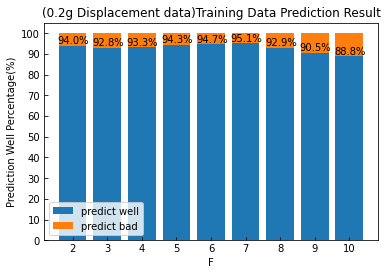

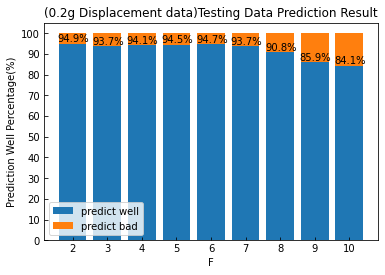

In [8]:
PerformanceIndex = 0.005

MSEList = [[Train_MSE,'(0.2g Displacement data)Training'],[Test_MSE,'(0.2g Displacement data)Testing']]
for sample in MSEList:
  GoodList = []
  BadList = []
  for i in range(9):
    StoryMSE = sample[0][:,i]
    GoodData = StoryMSE[StoryMSE<=PerformanceIndex]
    GoodList.append(GoodData.shape[0]/StoryMSE.shape[0]*100)
    BadList.append(100 - GoodData.shape[0] / StoryMSE.shape[0]*100)

  x = np.arange(9)+2
  plt.figure()
  plt.bar(x, GoodList, label='predict well')
  plt.bar(x, BadList, bottom=GoodList,label='predict bad')
  for xy in zip(x, GoodList):
    plt.annotate("%.1f" %xy[1]+'%', xy=xy, xytext=(-15, 2), textcoords='offset points')
  plt.title(sample[1]+' Data Prediction Result')
  plt.xlabel('F')
  plt.ylabel('Prediction Well Percentage(%)')
  plt.xticks(x)
  plt.yticks(np.arange(0, 105, 10))
  plt.legend(loc = 'lower left') 
  plt.show()



## Plot Structure Time History Response
將預測結果與真實反應疊圖比較，由表現最差排至表現最好

## Testing Data Set

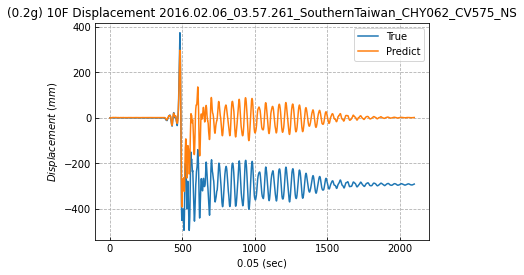

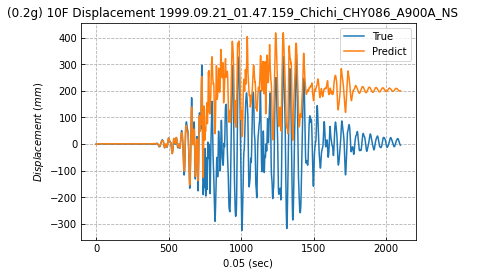

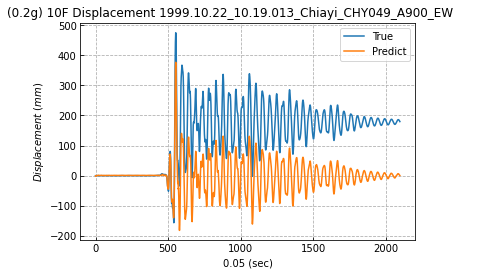

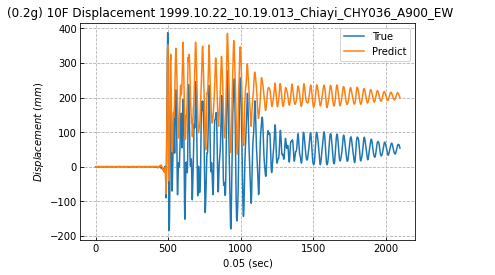

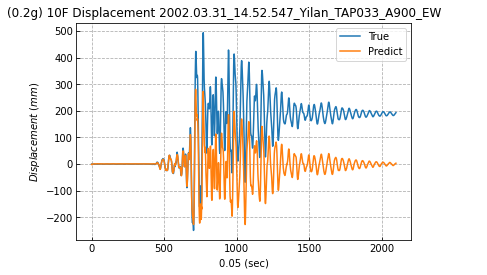

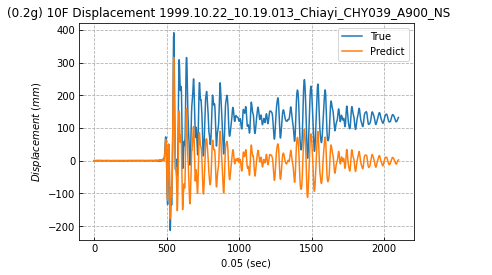

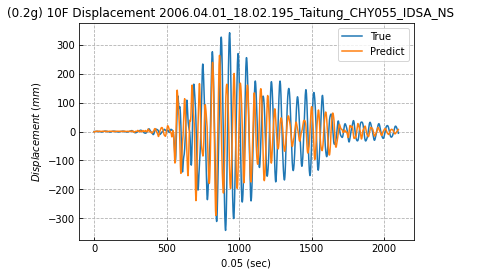

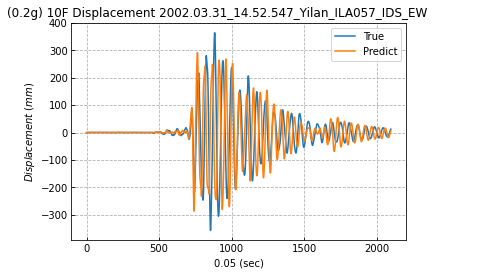

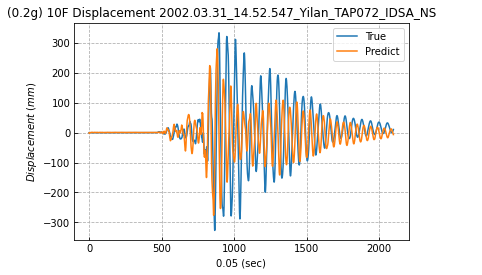

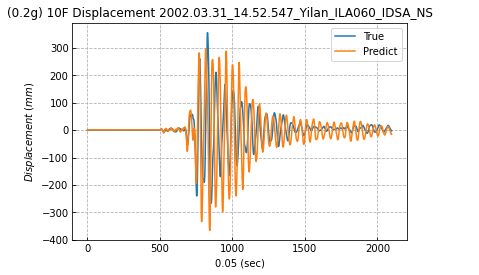

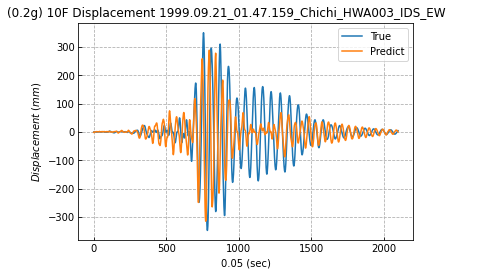

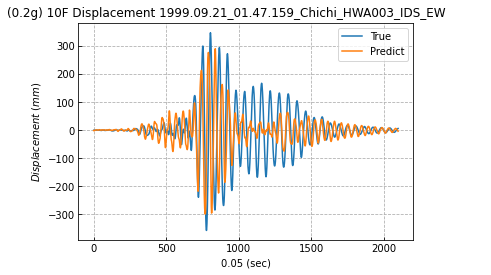

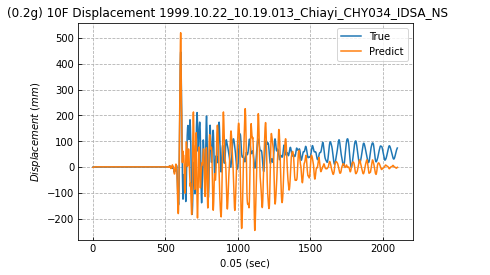

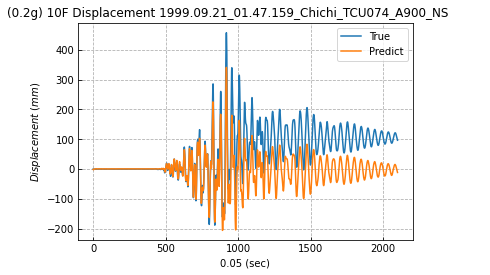

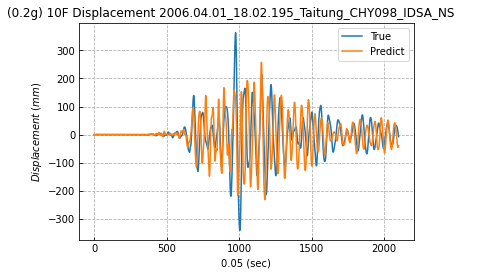

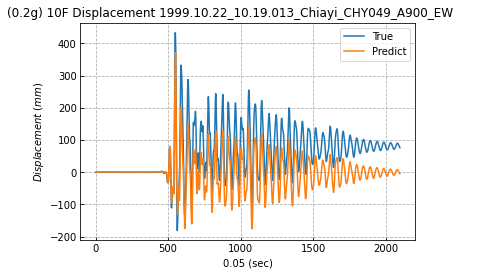

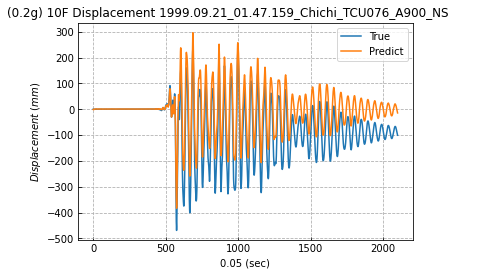

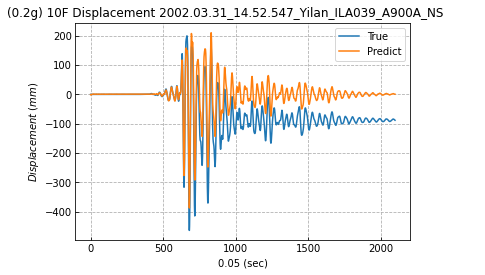

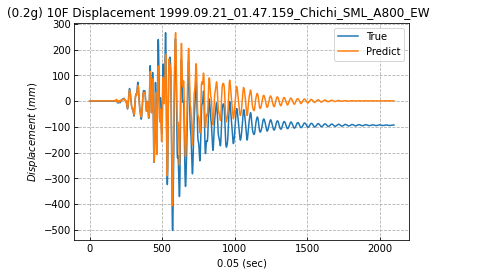

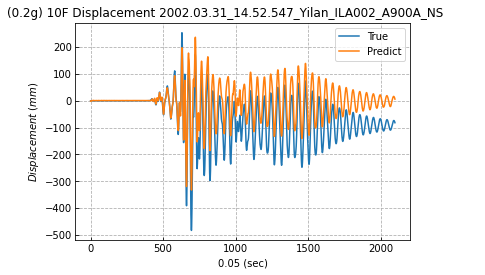

In [9]:
#-------------------------------------------------------------------------------
# Plot testing 
F = 10  #(輸入待觀察樓層)
F = F-2
for sample in top_Test[F,0:20]:  #先看部分data
  plt.figure()
  plt.plot(y_Disp_test_stack[sample][:, F], label='True')
  plt.plot(y_Disp_test_stack_pred[sample][:, F], label='Predict')
  plt.title('(0.2g) %dF Displacement '%(F+2)+name_test[sample])
  plt.xlabel('%.2f (sec)'%(0.05))
  plt.ylabel('$Displacement\ (mm)$')
  plt.rcParams['xtick.direction'] = 'in'
  plt.rcParams['ytick.direction'] = 'in'
  plt.grid(linestyle='--')
  plt.legend()

## Training Data Set

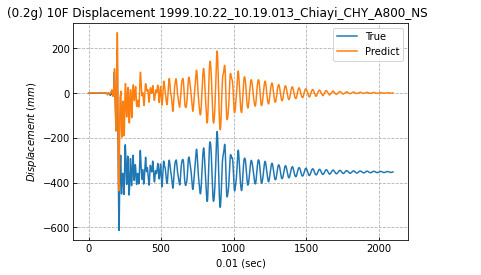

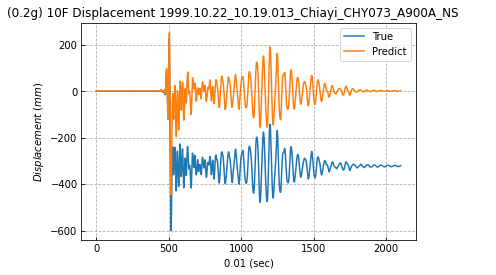

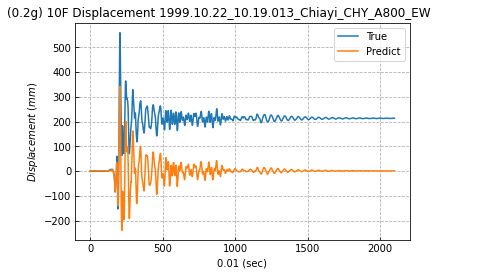

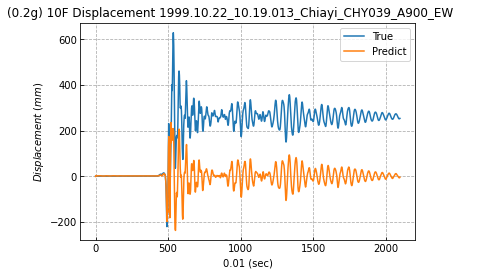

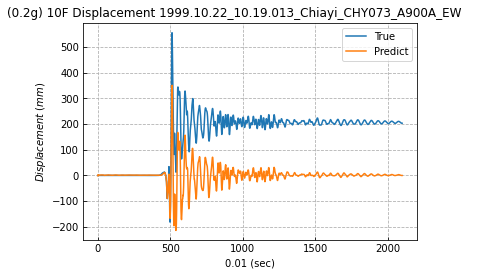

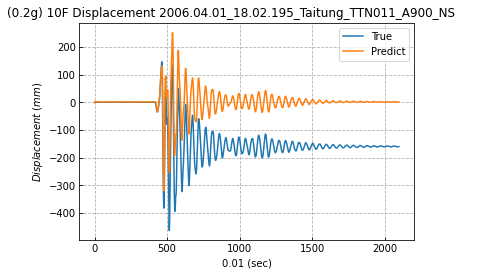

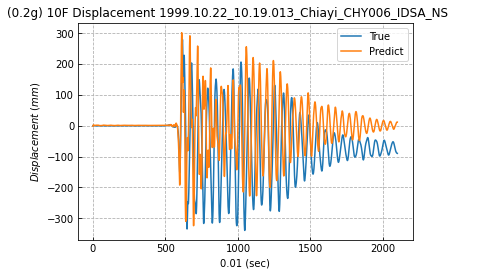

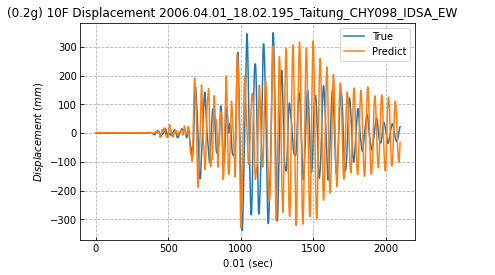

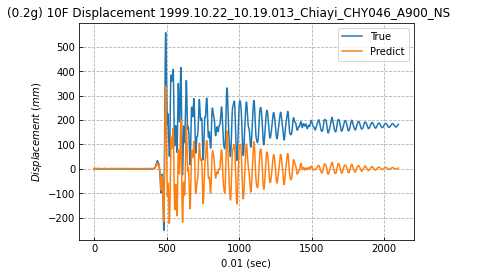

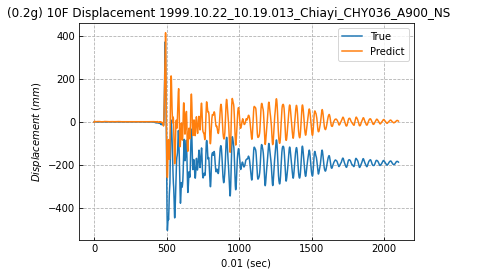

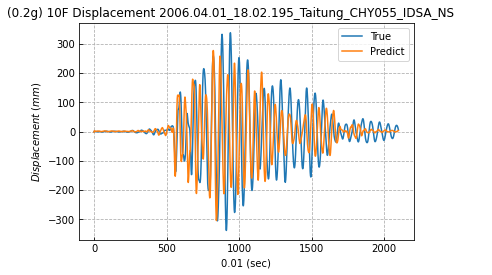

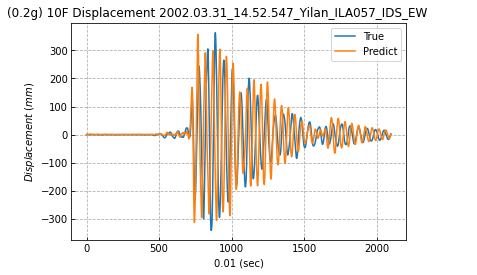

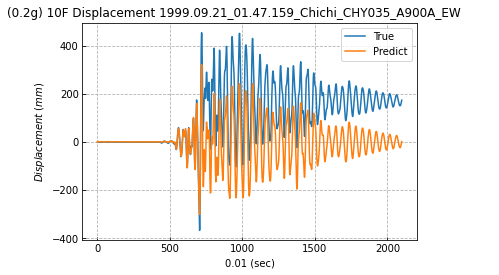

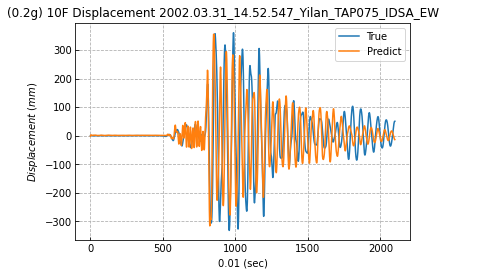

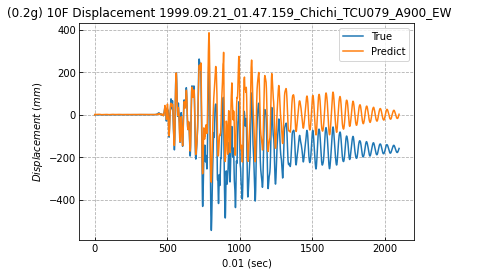

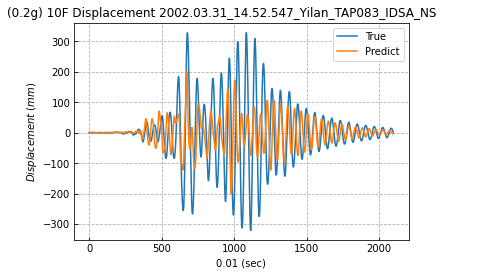

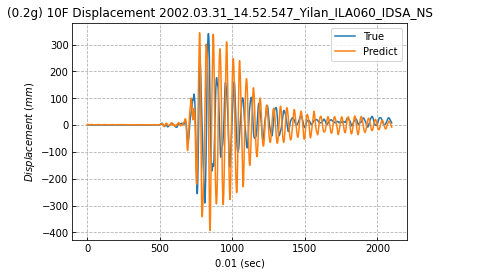

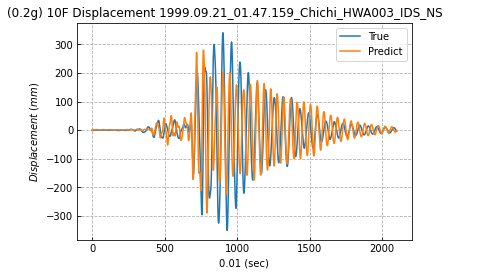

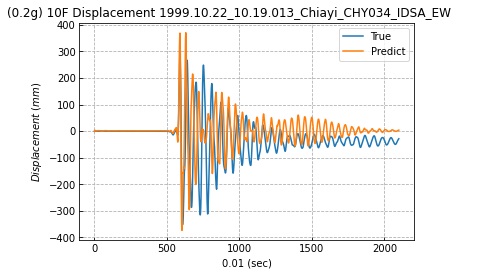

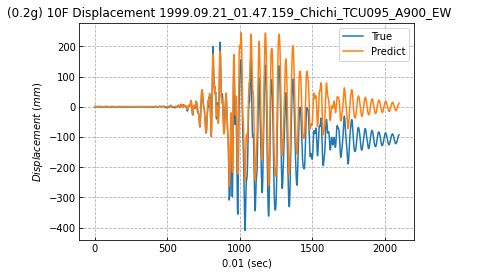

In [ ]:
#-------------------------------------------------------------------------------
# Plot Training data
F = 10  #(輸入待觀察樓層)
F = F-2
for sample in top_Train[F,0:20]:  #先看部分data
  plt.figure()    
  plt.plot(y_Disp_train_stack[sample][:, F], label='True')
  plt.plot(y_Disp_train_stack_pred[sample][:, F], label='Predict')
  plt.title('(0.2g) %dF Displacement '%(F+2)+name_train[sample])
  plt.xlabel('%.2f (sec)'%(0.005))
  plt.ylabel('$Displacement\ (mm)$')
  plt.rcParams['xtick.direction'] = 'in'
  plt.rcParams['ytick.direction'] = 'in'
  plt.grid(linestyle='--')
  plt.legend()